In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from tqdm import tqdm
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

sns.set(style='white', context='notebook', rc={'figure.figsize': (14, 10)})


### before merging

In [2]:
wksht_snps = pd.read_excel("worksheets/variantStats-v2.xlsb.xlsx", sheet_name="all")['SNPS'].tolist()

In [3]:
!ls -la recoded_hapmap_ped_case_control_vcf.h5


-rw-r--r-- 1 jbonnell kmem 3474462804 Aug  9 20:22 recoded_hapmap_ped_case_control_vcf.h5


In [4]:
df_1kg = pd.read_hdf("recoded_hapmap_ped_case_control_vcf.h5")
# for index in ['rs10865331',
#                      'rs2111485',
#                      'rs1295685',
#                      'rs848',
#                      'rs9504361',
#                      'rs11795343',
#                      'rs4561177',
#                      'rs8016947',
#                      'rs2041733',
#                      'rs16948048',
#                      'rs11652075']:
#     df_1kg[index] = df_1kg[index].fillna(df_1kg[index].mode().iloc[0])
# 'rs10994675', 'rs1327914', 'rs582757'


In [5]:
# df_1kg = df_1kg.iloc[:, 1:]
df_1kg['dataset'] = "1KG"

In [6]:
# df_1kg = df_1kg.drop(columns=['index'])
igsr_samples = pd.read_csv("IGSR/igsr_samples.tsv", delimiter="\t")
df_1kg = df_1kg.merge(igsr_samples, how="left", left_on="index", right_on="Sample name")
df_1kg = df_1kg.drop(columns=['index', 'Sample name', 'Biosample ID', 'Data collections'])
df_1kg

,rs11240777,rs6681049,rs4475691,rs72631889,rs13302982,rs2880024,rs2272757,rs13303010,rs3935066,rs6669800,...,rs9786255,rs41531144,group,dataset,Sex,Population code,Population name,Superpopulation code,Superpopulation name,Population elastic ID
0,1.0,2.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,cases,1KG,male,CEU,CEPH,EUR,European Ancestry,CEU
1,2.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,cases,1KG,male,GBR,British,EUR,European Ancestry,GBR
2,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,cases,1KG,male,GBR,British,EUR,European Ancestry,GBR
3,1.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,cases,1KG,female,CEU,CEPH,EUR,European Ancestry,CEU
4,0.0,2.0,1.0,0.0,2.0,1.0,0.0,2.0,2.0,2.0,...,0.0,0.0,cases,1KG,male,GBR,British,EUR,European Ancestry,GBR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,1.0,2.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,control,1KG,female,CEU,CEPH,EUR,European Ancestry,CEU
866,1.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,control,1KG,female,GBR,British,EUR,European Ancestry,GBR
867,1.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,control,1KG,female,CEU,CEPH,EUR,European Ancestry,CEU
868,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,control,1KG,female,CEU,CEPH,EUR,European Ancestry,CEU


In [14]:
with open("gen_info/blocks.info", "r") as f:
    sig_info1 = [eval(l.strip()) for l in f.readlines()[20:] if "----" not in l]
sig_info1 = set([item for sublist in sig_info1 for item in sublist])
print(len(sig_info1))
with open("gen_info_vcf/blocks.info", "r") as f:
    sig_info2 = [eval(l.strip()) for l in f.readlines()[20:] if "----" not in l]
sig_info2 = set([item for sublist in sig_info2 for item in sublist])
print(len(sig_info2))

40
30


In [8]:
# 1KG has 31 SNPs; the 1 remaining is rs10994675, which has discrepancy
set([c for c in list(df_1kg.columns) if c in set(wksht_snps)]) - sig_info 

{'rs10994675'}

In [9]:
df_hapmap = pd.read_hdf("recoded_hapmap_ped_case_control.h5")
with open("gen_info/col_map.pkl", "rb") as f:
    col_map = pickle.load(f)
# for int_index in ['rs4379175', 'rs13437088', 
#                   'rs582757', 'rs10738626', 'rs11652075', 'rs545979']:
#     index = int_index #col_map[int_index]
#     df_hapmap[index] = df_hapmap[index].fillna(df_hapmap[index].mode().iloc[0])


In [10]:
# rs_list = ['rs10994675', 'rs1327914', 'rs847', 'rs12295535', 'rs4379175', 'rs1250546', 'rs645078', 'rs17716942',
#            'rs11033603', 'rs582757', 'rs10738626', 'rs1056198', 'rs1665050', 'rs545979', 'rs4520482', 'rs12188300', 'rs6661961']
# a = [l for l in rs_list if l not in list(df_hapmap.columns)]
# # ['rs10994675', 'rs1327914', 'rs582757']
# a
# # ['rs10994675', 'rs1327914', 'rs582757']


In [13]:
df_hapmap = df_hapmap.iloc[:, 6:]
df_hapmap['dataset'] = "hapmap"

In [14]:
df_hapmap['Sex'] = "ok"
df_hapmap['Population code'] = "ok"
df_hapmap['Population name'] = "ok"
df_hapmap['Superpopulation code'] = "ok"
df_hapmap['Superpopulation name'] = "ok"
df_hapmap['Population elastic ID'] = "ok"

In [15]:
df_hapmap


,group,rs3131972,rs4970383,rs4475691,rs7537756,rs13302982,rs1110052,rs2272756,rs13303106,rs28415373,...,rs17149478,rs707689,rs6567787,dataset,Sex,Population code,Population name,Superpopulation code,Superpopulation name,Population elastic ID
0,cases,2,0,0,0,2,2,0,2,0,...,0,2,0,hapmap,ok,ok,ok,ok,ok,ok
1,cases,2,0,0,0,2,2,0,1,0,...,0,2,0,hapmap,ok,ok,ok,ok,ok,ok
2,cases,2,0,0,0,2,2,0,1,0,...,0,2,0,hapmap,ok,ok,ok,ok,ok,ok
3,cases,1,1,1,1,2,1,1,1,0,...,0,2,1,hapmap,ok,ok,ok,ok,ok,ok
4,cases,2,0,0,0,2,2,0,1,0,...,0,2,0,hapmap,ok,ok,ok,ok,ok,ok
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,control,2,1,0,0,2,2,0,2,0,...,0,2,0,hapmap,ok,ok,ok,ok,ok,ok
491,control,1,1,0,0,2,2,0,2,0,...,0,2,0,hapmap,ok,ok,ok,ok,ok,ok
492,control,1,0,0,0,2,1,1,1,0,...,0,2,1,hapmap,ok,ok,ok,ok,ok,ok
493,control,2,0,0,0,2,2,0,1,0,...,0,2,1,hapmap,ok,ok,ok,ok,ok,ok


In [16]:
df_merged = pd.concat([df_hapmap, df_1kg], ignore_index=True, sort=False)


In [17]:
del df_hapmap
del df_1kg

In [18]:
df_merged.to_hdf("together_hapmap_ped_case_control.h5", key="db", mode="w")


In [19]:
print("done")

done


### after merging

In [2]:
!ls -la together_hapmap_ped_case_control.h5


-rw-r--r-- 1 jbonnell kmem 8684176872 Aug 10 20:17 together_hapmap_ped_case_control.h5


In [3]:
df_merged = pd.read_hdf("together_hapmap_ped_case_control.h5")

In [11]:
wksht_snps = pd.read_excel(
    "worksheets/variantStats-v2.xlsb.xlsx", sheet_name="all")\
    .drop_duplicates(subset=['SNPS'])['SNPS']\
    .tolist()


In [5]:
df_merged  # 1365 rows × 792838


,group,rs3131972,rs4970383,rs4475691,rs7537756,rs13302982,rs1110052,rs2272756,rs13303106,rs28415373,...,rs3093463,rs3093535,rs2552791,rs3865913,rs35572756,rs9943032,rs7067398,rs35557642,rs9786255,rs41531144
0,cases,2.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cases,2.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,cases,2.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cases,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,cases,2.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360,control,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,...,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1361,control,NaN,NaN,0.0,NaN,2.0,NaN,NaN,NaN,NaN,...,0.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
1362,control,NaN,NaN,0.0,NaN,2.0,NaN,NaN,NaN,NaN,...,0.0,0.0,2.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0
1363,control,NaN,NaN,0.0,NaN,2.0,NaN,NaN,NaN,NaN,...,0.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0


In [6]:
with open("IGSR/missing_snp.pkl", "rb") as f:
    missing_snp = pickle.load(f)
print(len(missing_snp)) # 13
# 14 missing SNPs to bring 1KG to match hapmap3 data  (-4)
# hapmap3 data has its own 3 that are missing from worksheet
# that brings total missing snps to 17 (-4 now)

# rs10994675 - mismatch in ref alt 
# 'rs10994675', 'rs1327914', 'rs582757'
# ['rs10994675', 'rs1327914', 'rs582757']

13


In [25]:
to_drop = []
df_cols = list(df_merged.columns)
for i in tqdm(range(1, len(df_cols))):
    #3 in set(recoded_df[i].value_counts().index):
    if df_merged[df_cols[i]].isna().sum().sum() > 0:  # or \
        to_drop.append(df_cols[i])


100%|██████████| 792838/792838 [01:08<00:00, 11568.73it/s]


In [26]:
affected_snps = [t for t in to_drop if t in wksht_snps]
print(affected_snps) # 11
print(len(affected_snps)) # this is 14, not 17, b/c hapmap3 is missing 3 from wksht 
# this is not 10 b/c now 1KG has 1 SNP that is not present in hapmap3 
# use the list to fill in in run_ml.py
# ['rs847', 'rs4379175', 'rs12188300', 'rs10738626', 'rs4520482', 'rs1250546', 'rs645078', 'rs1665050', 'rs545979', 'rs1056198', 'rs10994675']
# NOTE there are SNP positions that are from the worksheet but do not make it part of the simulation, and we do not drop those SNP positions during the drop
# 11

['rs10865331', 'rs2111485', 'rs1295685', 'rs848', 'rs847', 'rs4379175', 'rs12188300', 'rs9504361', 'rs13437088', 'rs582757', 'rs10738626', 'rs11795343', 'rs4520482', 'rs1250546', 'rs645078', 'rs4561177', 'rs8016947', 'rs1665050', 'rs2041733', 'rs16948048', 'rs11652075', 'rs545979', 'rs1056198', 'rs10994675']
24


In [2]:
with open("gen_info/blocks.info", "r") as f:
    sig_info1 = [eval(l.strip())
                 for l in f.readlines()[20:] if "----" not in l]
sig_info1 = set([item for sublist in sig_info1 for item in sublist])

with open("gen_info_vcf/blocks.info", "r") as f:
    sig_info2 = [eval(l.strip())
                 for l in f.readlines()[20:] if "----" not in l]
sig_info2 = set([item for sublist in sig_info2 for item in sublist])
print(len(sig_info1))
print(len(sig_info2))
print(len(set(sig_info1).union(set(sig_info2))))
print(set(sig_info1).difference(sig_info2))
 # rs7130588 b/c wasn't used during hapmap3's simulation (not an error..)
print(set(sig_info2).difference(sig_info1))

40
30
41
{'rs4520482', 'rs12188300', 'rs1250546', 'rs1056198', 'rs582757', 'rs545979', 'rs847', 'rs645078', 'rs1665050', 'rs4379175', 'rs10738626'}
{'rs7130588'}


In [28]:
sig_snps = [c for c in list(df_merged.columns) if c in wksht_snps]
print(len(sig_snps))
with open("together_sig.pkl", "wb") as f:
    pickle.dump(sig_snps, f)
# can now do the supervised analysis for the merged..

42


In [29]:
print(len(to_drop))
to_drop = list(set(to_drop) - set(affected_snps))
print(len(to_drop))


527032
527008


In [30]:
df_merged = df_merged.drop(to_drop, axis=1)

In [31]:
df_merged  # 187537
# 1365 rows × 265830


,group,rs4475691,rs13302982,rs13303010,rs3935066,rs28391282,rs6665000,rs2341362,rs3128117,rs2465126,...,rs4933056,rs17149478,dataset,Sex,Population code,Population name,Superpopulation code,Superpopulation name,Population elastic ID,rs10994675
0,cases,0.0,2.0,2.0,2.0,0.0,2.0,2.0,1.0,2.0,...,1.0,0.0,hapmap,ok,ok,ok,ok,ok,ok,NaN
1,cases,0.0,2.0,1.0,1.0,0.0,2.0,2.0,2.0,2.0,...,1.0,0.0,hapmap,ok,ok,ok,ok,ok,ok,NaN
2,cases,0.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,hapmap,ok,ok,ok,ok,ok,ok,NaN
3,cases,1.0,2.0,2.0,2.0,0.0,2.0,2.0,1.0,2.0,...,0.0,0.0,hapmap,ok,ok,ok,ok,ok,ok,NaN
4,cases,0.0,2.0,1.0,1.0,0.0,2.0,2.0,1.0,2.0,...,0.0,0.0,hapmap,ok,ok,ok,ok,ok,ok,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360,control,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1KG,female,CEU,CEPH,EUR,European Ancestry,CEU,1.0
1361,control,0.0,2.0,2.0,2.0,0.0,2.0,2.0,1.0,2.0,...,0.0,0.0,1KG,female,GBR,British,EUR,European Ancestry,GBR,0.0
1362,control,0.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,2.0,...,0.0,0.0,1KG,female,CEU,CEPH,EUR,European Ancestry,CEU,2.0
1363,control,0.0,2.0,2.0,2.0,0.0,2.0,2.0,1.0,2.0,...,0.0,0.0,1KG,female,CEU,CEPH,EUR,European Ancestry,CEU,2.0


In [32]:
df_ancestry = df_merged[['Sex', 'Population code', 'Population name', 'Superpopulation code', 'Superpopulation name', 'Population elastic ID']].copy()
df_ancestry


,Sex,Population code,Population name,Superpopulation code,Superpopulation name,Population elastic ID
0,ok,ok,ok,ok,ok,ok
1,ok,ok,ok,ok,ok,ok
2,ok,ok,ok,ok,ok,ok
3,ok,ok,ok,ok,ok,ok
4,ok,ok,ok,ok,ok,ok
...,...,...,...,...,...,...
1360,female,CEU,CEPH,EUR,European Ancestry,CEU
1361,female,GBR,British,EUR,European Ancestry,GBR
1362,female,CEU,CEPH,EUR,European Ancestry,CEU
1363,female,CEU,CEPH,EUR,European Ancestry,CEU


In [33]:
df_merged = df_merged.drop(columns=['Sex', 'Population code', 'Population name', 'Superpopulation code', 'Superpopulation name', 'Population elastic ID'])
df_merged
# 1365 rows × 265825

,group,rs4475691,rs13302982,rs13303010,rs3935066,rs28391282,rs6665000,rs2341362,rs3128117,rs2465126,...,rs869131,rs12392452,rs4906979,rs35289520,rs35831186,rs28416357,rs4933056,rs17149478,dataset,rs10994675
0,cases,0.0,2.0,2.0,2.0,0.0,2.0,2.0,1.0,2.0,...,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hapmap,NaN
1,cases,0.0,2.0,1.0,1.0,0.0,2.0,2.0,2.0,2.0,...,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,hapmap,NaN
2,cases,0.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,hapmap,NaN
3,cases,1.0,2.0,2.0,2.0,0.0,2.0,2.0,1.0,2.0,...,2.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,hapmap,NaN
4,cases,0.0,2.0,1.0,1.0,0.0,2.0,2.0,1.0,2.0,...,2.0,0.0,2.0,0.0,1.0,2.0,0.0,0.0,hapmap,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360,control,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1KG,1.0
1361,control,0.0,2.0,2.0,2.0,0.0,2.0,2.0,1.0,2.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1KG,0.0
1362,control,0.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,2.0,...,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1KG,2.0
1363,control,0.0,2.0,2.0,2.0,0.0,2.0,2.0,1.0,2.0,...,2.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1KG,2.0


In [34]:
df_merged.to_hdf("together_hapmap_ped_case_control_supervised.h5", key="db") # for supervised analysis

In [35]:
for index in affected_snps:
    df_merged[index] = df_merged[index].fillna(df_merged[index].mode().iloc[0])

In [36]:
#df_X = df.iloc[:, 7:]
group = df_merged.pop('group')
dataset = df_merged.pop("dataset")


In [37]:
# df_y = pd.Series(group)
df_y = pd.Series(dataset)
df_y


0       hapmap
1       hapmap
2       hapmap
3       hapmap
4       hapmap
         ...  
1360       1KG
1361       1KG
1362       1KG
1363       1KG
1364       1KG
Name: dataset, Length: 1365, dtype: object

In [38]:
df_merged # 187535


,rs4475691,rs13302982,rs13303010,rs3935066,rs28391282,rs6665000,rs2341362,rs3128117,rs2465126,rs2341365,...,rs1894356,rs869131,rs12392452,rs4906979,rs35289520,rs35831186,rs28416357,rs4933056,rs17149478,rs10994675
0,0.0,2.0,2.0,2.0,0.0,2.0,2.0,1.0,2.0,2.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,2.0,1.0,1.0,0.0,2.0,2.0,2.0,2.0,2.0,...,0.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
2,0.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,2.0,2.0,2.0,0.0,2.0,2.0,1.0,2.0,2.0,...,0.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0
4,0.0,2.0,1.0,1.0,0.0,2.0,2.0,1.0,2.0,2.0,...,0.0,2.0,0.0,2.0,0.0,1.0,2.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1361,0.0,2.0,2.0,2.0,0.0,2.0,2.0,1.0,2.0,2.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1362,0.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,2.0,2.0,...,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0
1363,0.0,2.0,2.0,2.0,0.0,2.0,2.0,1.0,2.0,2.0,...,1.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0


generate file for doing SNP distribution comparison (R code)

In [31]:
snps_to_compare = [t for t in list(df_merged.columns) if t in wksht_snps]
len(snps_to_compare)


30

In [32]:
for_comparison = df_merged[snps_to_compare].copy()
for_comparison['dataset'] = dataset


In [33]:
for_comparison


,rs7552167,rs6661961,rs6677595,rs10865331,rs759382,rs2111485,rs17716942,rs1295686,rs1295685,rs848,...,rs8016947,rs2041733,rs12445568,rs4796793,rs16948048,rs11652075,rs12720356,rs892085,rs4821544,dataset
0,2.0,0.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,hapmap
1,2.0,1.0,2.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,2.0,hapmap
2,2.0,1.0,2.0,1.0,2.0,1.0,0.0,2.0,1.0,1.0,...,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,hapmap
3,2.0,1.0,1.0,1.0,2.0,1.0,0.0,2.0,2.0,2.0,...,1.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,hapmap
4,2.0,2.0,0.0,2.0,2.0,1.0,0.0,2.0,1.0,1.0,...,2.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0,1.0,hapmap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2146,2.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1KG
2147,2.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,2.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,2.0,1KG
2148,2.0,2.0,1.0,0.0,2.0,1.0,0.0,2.0,2.0,2.0,...,1.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1KG
2149,2.0,2.0,1.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,2.0,2.0,0.0,1.0,1.0,2.0,0.0,1KG


In [34]:
# for_comparison.to_csv("df_together_compare.csv", index=False)
for_comparison.to_hdf("df_together_compare_nowksht.h5", index=False, key="db")

In [14]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(df_merged)

In [15]:
kmeans.labels_


array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [21]:
print(sum(df_y.map({"1KG": 0, "hapmap": 1}).to_numpy()
          == 0) / len(df_y))
print(sum(df_y.map({"1KG": 0, "hapmap": 1}).to_numpy()
          == 1) / len(df_y))


0.7698744769874477
0.2301255230125523


In [26]:
print(sum((0== kmeans.labels_)) / len(kmeans.labels_))
print(sum((1== kmeans.labels_)) / len(kmeans.labels_))

0.006508600650860065
0.9934913993491399


In [20]:
print(sum(df_y.map({"1KG": 0, "hapmap": 1}).to_numpy() == kmeans.labels_) / len(df_y))
print(sum(df_y.map({"1KG": 1, "hapmap": 0}).to_numpy() == kmeans.labels_) / len(df_y))

0.23198512319851233
0.7680148768014877


In [19]:
sum(df_y.map({"control": 0, "cases": 1}).to_numpy() == kmeans.labels_) / len(df_y)

0.0

In [39]:
# TODO impute missing values separately datasets and then after datasets have been merged 
# TODO k-means clustering 
reducer = umap.UMAP(n_neighbors=200, n_components=2)  # 150)#15)
# print(len(X_transformed[1]))
X_embedded = reducer.fit_transform(df_merged)


In [40]:
for_viz = pd.DataFrame({
    'x':X_embedded[:, 0],
    'y':X_embedded[:, 1],
    # 'z':X_embedded[:, 2],
    'sex':df_ancestry['Sex'].tolist(), 
    'Population code': df_ancestry['Population code'].tolist(),
    'Population name': df_ancestry['Population name'].tolist(),
    'Superpopulation code':df_ancestry['Superpopulation code'].tolist(), 
    'Superpopulation name':df_ancestry['Superpopulation name'].tolist(), 
    'Population elastic ID':df_ancestry['Population elastic ID'].tolist(), 
    'group': group, 
    'dataset': dataset
    #'kmeans': kmeans.labels_
})
for_viz.to_csv("unsupervised_res_kmeans.csv") # to R!


In [41]:
!ls -la unsupervised_res_kmeans.csv

-rw-r--r-- 1 jbonnell kmem 97365 Aug 10 20:55 unsupervised_res_kmeans.csv


In [18]:
df_y.map({"control": 0, "cases": 1})


0       1
1       1
2       1
3       1
4       1
       ..
2146    0
2147    0
2148    0
2149    0
2150    0
Name: group, Length: 2151, dtype: int64

In [25]:
# umap_c_0 = []
# umap_c_1 = []
# umap_c_0_c = []
# umap_c_1_c = []
# for index,y in enumerate(df_y.map({"control": 0, "cases": 1})):
# # for index,y in enumerate(df_y.map({"hapmap": 0, "1KG": 1})):
#     if y == 1: 
#         umap_c_1.append(X_embedded[index])
#         umap_c_1_c.append(y)
#     else:
#         umap_c_0.append(X_embedded[index])
#         umap_c_0_c.append(y)
# umap_c_0 = np.asarray(umap_c_0)
# umap_c_1 = np.asarray(umap_c_1)

In [26]:
df_y

0       hapmap
1       hapmap
2       hapmap
3       hapmap
4       hapmap
         ...  
2146       1KG
2147       1KG
2148       1KG
2149       1KG
2150       1KG
Name: dataset, Length: 2151, dtype: object

<Figure size 1008x720 with 0 Axes>

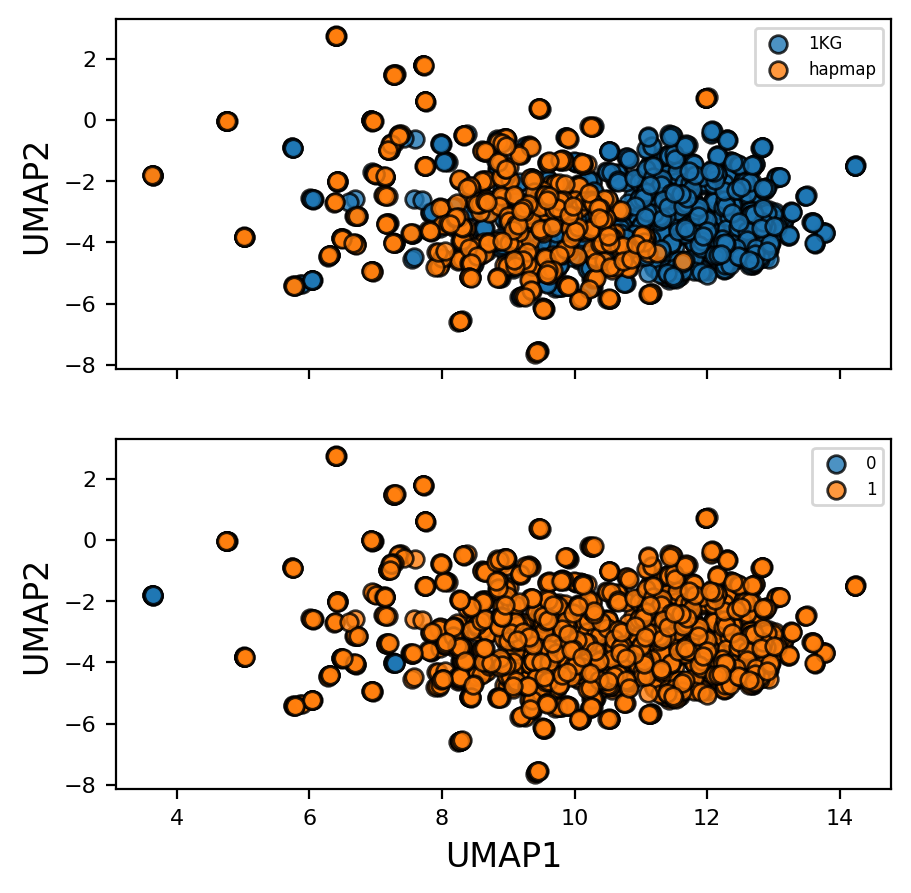

In [22]:
import matplotlib as mpl
plt.clf()
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'figure.figsize': (10, 10)})

# %matplotlib inline
%config InlineBackend.figure_format = 'retina'

params = {
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 8,  # fontsize for x and y labels (was 10)
    'axes.titlesize': 8,
    'font.size': 8,  # was 10
    'legend.fontsize': 6,  # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'figure.figsize': [5, 5]  # [6, 6]
}
mpl.rcParams.update(params)


fig, (ax1, ax2) = plt.subplots(2,1,sharex=True, sharey=True)
# fig, (ax1) = plt.subplots(1,sharex=True, sharey=True)
# fig.suptitle('Vertically stacked subplots')
scatter_df = pd.DataFrame({
    'x':X_embedded[:, 0],
    'y':X_embedded[:, 1],
    'group':[y for y in df_y.to_numpy()],
    'c':[y for y in df_y.map({"control": 0, "cases": 1}).to_numpy()],
    'k':kmeans.labels_
})
for i, (name, group) in enumerate(scatter_df.groupby("group")): 
    sc = ax1.scatter(group['x'], group['y'], 
                #c=group['c'],
                label=name,
                #cmap=sns.color_palette("flare", as_cmap=True),
                edgecolors='black',
                s=40, alpha=0.8)
# colorbar(scatters)
ax1.legend()
# axs[0].scatter(umap_c_1[:, 0], umap_c_1[:, 1], c=[sns.color_palette()[y] for y in umap_c_1_c],
#             label="cases", s=40, alpha=0.8)
for i, (name, group) in enumerate(scatter_df.groupby("k")):
    sc = ax2.scatter(group['x'], group['y'],
                # c=group['k'], 
                label=name,
                # cmap=sns.color_palette("flare", as_cmap=True),
                edgecolors='black',
                s=40, alpha=0.8)
ax2.legend()
# colorbar(scatters)
# ax2.autoscale(False, axis="x")
# axs[1].scatter(umap_c_1[:, 0], umap_c_1[:, 1], c=[sns.color_palette()[y] for y in kmeans1_c],
#                label="cases", s=40, alpha=0.8)



# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP Visualization\n(Excluding Associated SNPs)', fontsize=24)
# ax1.set_xlabel('UMAP1', fontsize=12)
ax1.set_ylabel('UMAP2', fontsize=12)
ax2.set_xlabel('UMAP1', fontsize=12)
ax2.set_ylabel('UMAP2', fontsize=12)
# axs[0].legend()
plt.show()
# plt.savefig("umap-no.png")


<Figure size 500x500 with 0 Axes>

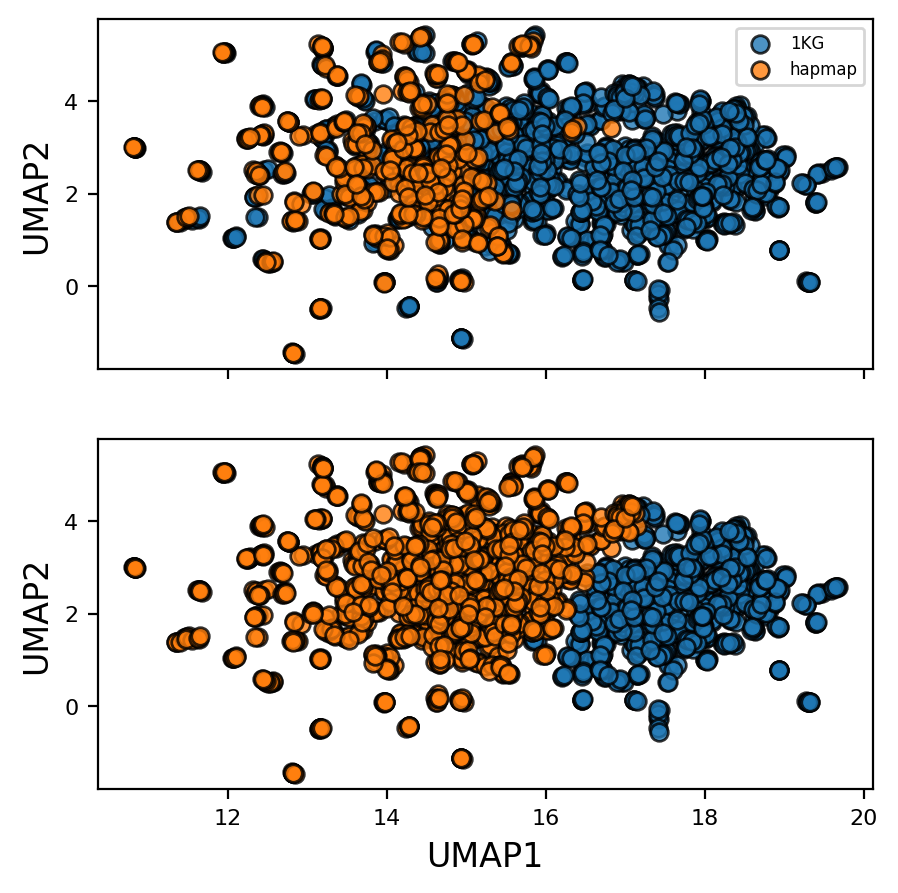

In [36]:
import matplotlib as mpl
plt.clf()
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'figure.figsize': (10, 10)})

# %matplotlib inline
%config InlineBackend.figure_format = 'retina'

params = {
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 8,  # fontsize for x and y labels (was 10)
    'axes.titlesize': 8,
    'font.size': 8,  # was 10
    'legend.fontsize': 6,  # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'figure.figsize': [5, 5]  # [6, 6]
}
mpl.rcParams.update(params)


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
# fig, (ax1) = plt.subplots(1,sharex=True, sharey=True)
# fig.suptitle('Vertically stacked subplots')
scatter_df = pd.DataFrame({
    'x': X_embedded[:, 0],
    'y': X_embedded[:, 1],
    'group': [y for y in df_y.to_numpy()],
    'c': [y for y in df_y.map({"1KG": 0, "hapmap": 1}).to_numpy()],
    'k': kmeans.labels_
})
for i, (name, group) in enumerate(scatter_df.groupby("group")):
    sc = ax1.scatter(group['x'], group['y'],
                     #c=group['c'],
                     label=name,
                     #cmap=sns.color_palette("flare", as_cmap=True),
                     edgecolors='black',
                     s=40, alpha=0.8)
# colorbar(scatters)
ax1.legend()
# axs[0].scatter(umap_c_1[:, 0], umap_c_1[:, 1], c=[sns.color_palette()[y] for y in umap_c_1_c],
#             label="cases", s=40, alpha=0.8)
for i, (name, group) in enumerate(scatter_df.groupby("k")):
    sc = ax2.scatter(group['x'], group['y'],
                     # c=group['k'],
                     label=name,
                     # cmap=sns.color_palette("flare", as_cmap=True),
                     edgecolors='black',
                     s=40, alpha=0.8)
# ax2.legend()
# colorbar(scatters)
# ax2.autoscale(False, axis="x")
# axs[1].scatter(umap_c_1[:, 0], umap_c_1[:, 1], c=[sns.color_palette()[y] for y in kmeans1_c],
#                label="cases", s=40, alpha=0.8)


# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP Visualization\n(Excluding Associated SNPs)', fontsize=24)
# ax1.set_xlabel('UMAP1', fontsize=12)
ax1.set_ylabel('UMAP2', fontsize=12)
ax2.set_xlabel('UMAP1', fontsize=12)
ax2.set_ylabel('UMAP2', fontsize=12)
# axs[0].legend()
# plt.show()
plt.savefig("umap-datasets.png")
